In [1]:
#importing useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


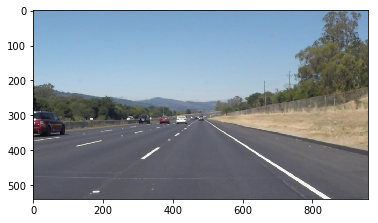

In [2]:
#reading in an image
imgtemp = cv2.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
image = cv2.cvtColor(imgtemp, cv2.COLOR_BGR2RGB) # cv2 brings BGR format so need to convert as RGB for processing
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
def hsv(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)
def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image
def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img           
def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

In [4]:
## Test Images 
##Build your pipeline to work on the images in the directory "test_images"  
##**You should make sure your pipeline works well on these images before you try the videos.**

In [5]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

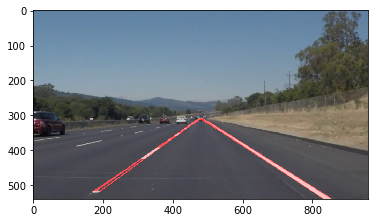

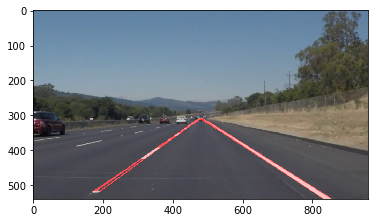

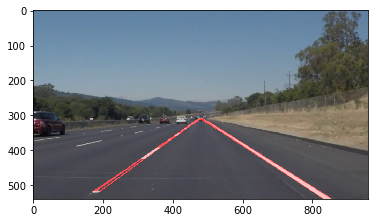

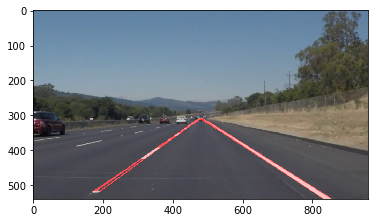

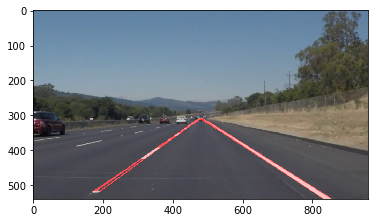

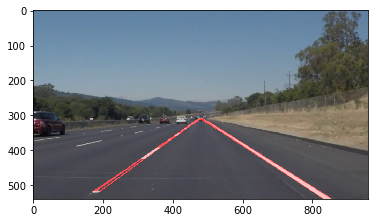

In [6]:
#reading in an image
for index, img in enumerate(os.listdir("test_images/")):
    imagtemp = cv2.imread('test_images/' + img)
    #printing out some stats and plotting
    image = cv2.cvtColor(imgtemp, cv2.COLOR_BGR2RGB)
    gray_img = grayscale(image)    

    hsv_img = hsv(image)
    
    # define range of color in HSV
    lower_yel = np.array([20,100,100])
    upper_yel = np.array([30,255,255])
    lower_wht = np.array([0,0,235])
    upper_wht = np.array([255,255,255])
    
    # Threshold the HSV image to get only yellow/white 
    yellow_mask = cv2.inRange(hsv_img, lower_yel, upper_yel)
    white_mask = cv2.inRange(hsv_img, lower_wht, upper_wht)
    # Bitwise-AND mask and original image
    full_mask = cv2.bitwise_or(yellow_mask, white_mask)
    
    subdued_gray = (gray_img / 2).astype('uint8')
    
    boosted_lanes = cv2.bitwise_or(subdued_gray, full_mask)

    kernel_size = 5
    blurred_img = gaussian_blur(boosted_lanes,kernel_size)
    
    canny_low_threshold = 60
    canny_high_threshold = 150
    edges_img = canny(blurred_img,canny_low_threshold,canny_high_threshold)
    
    x = edges_img.shape[1]
    y = edges_img.shape[0]
    vertices = np.array([[(x*0.,y),(x*.475, y*.575), (x*.525, y*.575), (x,y)]], dtype=np.int32)
    masked_img = region_of_interest(edges_img, vertices)
    
    hough_rho = 3
    hough_theta = np.pi/180
    hough_threshold = 70
    hough_min_line_length = 70
    hough_max_line_gap = 250
    hough_img = hough_lines(masked_img,hough_rho,hough_theta,hough_threshold,hough_min_line_length,hough_max_line_gap)
    
    result = weighted_img(hough_img,image)
 
    fig = plt.figure(figsize=(6,10))
    plt.imshow(result, cmap="gray")  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image


In [7]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [8]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
       
    gray_img = grayscale(image)    

    hsv_img = hsv(image)
    
    # define range of color in HSV
    lower_yel = np.array([20,100,100])
    upper_yel = np.array([30,255,255])
    lower_wht = np.array([0,0,235])
    upper_wht = np.array([255,255,255])
    
    # Threshold the HSV image to get only yellow/white 
    yellow_mask = cv2.inRange(hsv_img, lower_yel, upper_yel)
    white_mask = cv2.inRange(hsv_img, lower_wht, upper_wht)
    # Bitwise-AND mask and original image
    full_mask = cv2.bitwise_or(yellow_mask, white_mask)
    
    subdued_gray = (gray_img / 2).astype('uint8')
    
    boosted_lanes = cv2.bitwise_or(subdued_gray, full_mask)

    kernel_size = 5
    blurred_img = gaussian_blur(boosted_lanes,kernel_size)
    
    canny_low_threshold = 60
    canny_high_threshold = 150
    edges_img = canny(blurred_img,canny_low_threshold,canny_high_threshold)
    
    x = edges_img.shape[1]
    y = edges_img.shape[0]
    vertices = np.array([[(x*0.,y),(x*.475, y*.575), (x*.525, y*.575), (x,y)]], dtype=np.int32)
    masked_img = region_of_interest(edges_img, vertices)
    
    hough_rho = 3
    hough_theta = np.pi/180
    hough_threshold = 70
    hough_min_line_length = 70
    hough_max_line_gap = 250
    hough_img = hough_lines(masked_img,hough_rho,hough_theta,hough_threshold,hough_min_line_length,hough_max_line_gap)
    
    result = weighted_img(hough_img,image)
    
    #return cv2.cvtColor(masked_img, cv2.COLOR_GRAY2RGB)
    return result

In [9]:
## video of solid white lane on the right ...

In [10]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|███████████████████████████████████████▊| 221/222 [00:23<00:00,  7.24it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

Wall time: 27.7 s


In [11]:
## video of solid white lane on the left ...

In [12]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [13]:
yellow_output = 'yellow.mp4'
clip1 = VideoFileClip("solidYellowLeft.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|███████████████████████████████████████▉| 681/682 [01:27<00:00,  8.81it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

Wall time: 1min 30s


In [14]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))